<a href="https://colab.research.google.com/github/GiovaniValdrighi/inferencia_causal/blob/master/scm_counterfactual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl
!pip3 install torchvision
!pip3 install pyro-ppl

ERROR: torch-0.4.0-{platform}-linux_x86_64.whl is not a valid wheel filename.


In [0]:
import numpy as np
import torch
from vae_build import VAE, ind_from_att, label_from_dummy
import pyro
import matplotlib.pyplot as plt

In [5]:
dataset_zip = np.load('/content/gdrive/My Drive/autoencoder/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle = True, encoding = 'bytes')
print('Keys in the dataset:', dataset_zip.files)
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
latents_sizes = dataset_zip['metadata'][()][b'latents_sizes']
latents_names = dataset_zip['metadata'][()][b'latents_names']

Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']


In [6]:
#pyro.enable_validation(True)
pyro.clear_param_store()
#the training routine
use_CUDA = False
vae = VAE(latents_sizes, latents_names, use_CUDA = use_CUDA)
vae.load_state_dict(torch.load('/content/gdrive/My Drive/trained_movel_epoch_24.save'))

<All keys matched successfully>

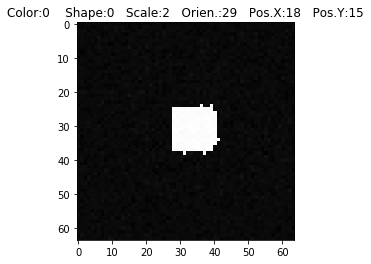

In [34]:
class SCM():
  def __init__(self, vae):
    self.vae = vae
    self.latents_names = ['color', 'shape', 'scale', 'orien', 'posX', 'posY']
    self.latents_sizes = {'color' : 1, 'shape': 3, 'scale':6, 'orien': 40, 'posX': 32, 'posY':32}
    self.init_noise = {}
    for key, value in self.latents_sizes.items():
      prob = torch.tensor([1/value]).repeat(value)
      self.init_noise[key] = pyro.distributions.OneHotCategorical(prob)
    self.init_noise['latent'] = pyro.distributions.Normal(torch.zeros(200), torch.ones(200))
    self.init_noise['img'] = pyro.distributions.Uniform(torch.zeros(4096), torch.ones(4096))
    
    #functions for the model
    def f_gumbel(N):
      return N

    def f_latent(N_latent, ind, label):
      mu, sigma = vae.encoder.forward(torch.tensor(imgs[ind]).reshape(4096).to(torch.float32), label)
      return N_latent * sigma + mu

    def f_image(N_img, latent, label):
      img_decode = vae.decoder.forward(latent, label)
      return (N_img > img_decode).to(torch.float)

    def f_posX(N, scale):
      if 31 <= int(scale.max(0)[1]*3 + N.max(0)[1]):
        return torch.nn.functional.one_hot(torch.tensor([31]), 32).to(torch.float32).reshape([32])
      else:
        return torch.nn.functional.one_hot(scale.max(0)[1]*3 + N.max(0)[1], 32).to(torch.float32).reshape([32])

    def model(noise = self.init_noise):

      #Noise variables
      N_color = pyro.sample('N_color', noise['color'])
      N_shape = pyro.sample('N_shape', noise['shape'])
      N_scale = pyro.sample('N_scale', noise['scale'])
      N_orien = pyro.sample('N_orien', noise['orien'])
      N_posX = pyro.sample('N_posX', noise['posX'])
      N_posY = pyro.sample('N_posY', noise['posY'])
      N_latent = pyro.sample('N_latent', noise['latent'])
      N_img = pyro.sample('N_img', noise['img'])

      
      #variables
      color = pyro.sample('color', pyro.distributions.Normal(f_gumbel(N_color), torch.tensor([0.01])).to_event(1))
      shape = pyro.sample('shape', pyro.distributions.Normal(f_gumbel(N_shape), torch.tensor([0.01])).to_event(1))
      scale = pyro.sample('scale', pyro.distributions.Normal(f_gumbel(N_scale), torch.tensor([0.01])).to_event(1))
      orien = pyro.sample('orien', pyro.distributions.Normal(f_gumbel(N_orien), torch.tensor([0.01])).to_event(1))
      posX = pyro.sample('posX', pyro.distributions.Normal(f_posX(N_posX, scale), torch.tensor([0.01])).to_event(1))
      posY = pyro.sample('posY', pyro.distributions.Normal(f_gumbel(N_posY), torch.tensor([0.01])).to_event(1))
      
      #fixing values to the decoder
      ind = ind_from_att(color.max(0)[1], shape.max(0)[1], scale.max(0)[1], orien.max(0)[1], posX.max(0)[1], posY.max(0)[1])
      label = torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1))
      
      #variables
      latent = pyro.sample('latent', pyro.distributions.Normal(f_latent(N_latent, ind, label), torch.tensor([0.01])).to_event(1))
      img = pyro.sample('img', pyro.distributions.Normal(f_image(N_img, latent, label), torch.tensor([0.01])).to_event(1))

      return label, latent, img
    
    def guide(noise):
      #setting noises categorical parameters (probs)
      prob_param = {}
      for key, value in self.latents_sizes.items():
        prob = torch.tensor([1/value]).repeat(value)
        prob_param['N_'+key] = pyro.param('probs_N_'+key, prob, constraint = pyro.distributions.constraints.interval(0.001, 0.999))

      #categorical samples      
      for key, value in prob_param.items():
        pyro.sample(key, pyro.distributions.RelaxedOneHotCategorical(torch.tensor([0.01]), probs = value))

      #seting normal noises parameters
      mean_N_latent = pyro.param('mean_N_latent', torch.zeros(200), constraint = pyro.distributions.constraints.interval(torch.tensor([0.0]), torch.tensor([1.0])))
      var_N_latent = pyro.param('var_N_latent', torch.ones(200), constraint = pyro.distributions.constraints.interval(torch.tensor([0.0]), torch.tensor([1.0])))
      mean_N_img = pyro.param('mean_N_img', torch.zeros(4096), constraint = pyro.distributions.constraints.interval(torch.tensor([0.0]), torch.tensor([1.0])))
      var_N_img = pyro.param('var_N_img', torch.ones(4096), constraint = pyro.distributions.constraints.interval(torch.tensor([0.0]), torch.tensor([1.0])))
     
      #normal samples
      pyro.sample('N_latent', pyro.distributions.Normal(mean_N_latent, var_N_latent))
      pyro.sample('N_img', pyro.distributions.Normal(mean_N_img, var_N_img))
      
      return 
    
    def counterfactual(var_name, obs_var, counter_var, n_steps = 1000):
      #calculating noise posterior in the observation model
      obsModel = pyro.condition(model, data = {var_name : obs_var})
      pyro.clear_param_store()

      #setting the SVI attributes
      adam_params = {'lr': 0.001}
      optmizer = pyro.optim.Adam(adam_params)
      elbo = pyro.infer.Trace_ELBO()
      svi = pyro.infer.SVI(obsModel, guide, optmizer, elbo)

      #training loop
      losses = []
      noise_cat_samples = {'N_'+noise:[] for noise in self.latents_names}
      noise_mean_samples = {'N_latent': [] , 'N_img' : []}
      noise_var_samples = {'N_latent': [], 'N_img' : []}
      for i in range(n_steps):
        print(i)
        losses.append(svi.step(self.init_noise))
        #saving samples
        for latent in self.latents_names:
          noise_cat_samples['N_'+latent].append(pyro.param('probs_N_'+latent))
        noise_mean_samples['N_latent'].append(pyro.param('mean_N_latent'))
        noise_mean_samples['N_img'].append(pyro.param('mean_N_img'))
        noise_var_samples['N_latent'].append(pyro.param('var_N_latent'))
        noise_var_samples['N_img'].append(pyro.param('var_N_img'))
      
      #calculating means
      mean_val = {}
      for latent in self.latents_names:
        mean_val['prob_'+latent] = torch.mean(torch.stack(noise_cat_samples['N_'+latent]), dim = 0)
      mean_val['loc_latent'] = torch.mean(torch.stack(noise_mean_samples['N_latent']), dim = 0)
      mean_val['loc_img'] = torch.mean(torch.stack(noise_mean_samples['N_img']), dim = 0)
      mean_val['scale_latent'] = torch.mean(torch.stack(noise_var_samples['N_latent']), dim = 0)
      mean_val['scale_img'] = torch.mean(torch.stack(noise_var_samples['N_img']), dim = 0)

      updated_noise = {}
      for latent in self.latents_names:
        updated_noise[latent] = pyro.distributions.OneHotCategorical(mean_val['prob_'+latent])
      updated_noise['latent'] = pyro.distributions.Normal(mean_val['loc_latent'], mean_val['scale_latent'])
      updated_noise['img'] = pyro.distributions.Normal(mean_val['loc_img'], mean_val['scale_img'])


      #counterfactual query with updated noise
      intModel = pyro.do(model, data = {var_name : counter_var})
      cf_posterior = pyro.infer.Importance(intModel, guide, n_steps).run(updated_noise)
      cf_marginal = pyro.infer.EmpiricalMarginal(cf_posterior, sites = 'img')
      return cf_marginal.mean

    def viz_model():
      label, _, img = model()
      label = label_from_dummy(label)
      plt.imshow(img.detach().numpy().reshape(64, 64), cmap = 'Greys')
      text = 'Color:0    Shape:'+str(int(label[1])) + '   Scale:' + str(int(label[2])) + '   Orien.:' + str(int(label[3])) + '   Pos.X:' + str(int(label[4])) + '   Pos.Y:' + str(int(label[5]))
      plt.title(text)
      plt.show()

    self.model = model
    self.guide = guide
    self.viz_model = viz_model
    self.counterfactual = counterfactual


scm = SCM(vae)
scm.viz_model()

In [33]:
scm.counterfactual('shape', torch.tensor([1., 0., 0.]), torch.tensor([0., 1., 0.]))

0
1
2
3
4
5


/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133


KeyboardInterrupt: ignored